## 라이브러리 설치 및 데이터 불러오기

In [1]:
import h5py
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D, LSTM, Bidirectional, GRU, Attention, Input, Activation, Add, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 불필요한 경고 메시지 비활성화
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

In [2]:
# 파일 경로 지정
file_path = '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/week05 (MATLAB dataset)/p027710.mat'

In [3]:
# HDF5 형식의 .mat 파일을 읽어 데이터 추출
with h5py.File(file_path, 'r') as mat_file:
    print(f"✅ '{file_path}' 파일 열기 성공!")

    # 'Subj_Wins' 그룹으로 이동
    subj_wins_group = mat_file['Subj_Wins']

    # 각 데이터셋의 참조를 해결하여 실제 숫자 배열을 가져옴
    sbp_refs = subj_wins_group['SegSBP'][()]
    dbp_refs = subj_wins_group['SegDBP'][()]
    ecg_refs = subj_wins_group['ECG_F'][()] # 필터링된 ECG 신호
    ppg_refs = subj_wins_group['PPG_F'][()] # 필터링된 PPG 신호

    # 참조 목록을 순회하며 실제 숫자 값을 가져와 새로운 리스트 생성
    sbp = np.array([mat_file[ref][()].flatten()[0] for ref in sbp_refs.flatten()])
    dbp = np.array([mat_file[ref][()].flatten()[0] for ref in dbp_refs.flatten()])

    # ECG와 PPG 신호는 각 세그먼트가 여러 샘플을 가지므로 리스트로 유지
    ecg_signals = [mat_file[ref][()].flatten() for ref in ecg_refs.flatten()]
    ppg_signals = [mat_file[ref][()].flatten() for ref in ppg_refs.flatten()]

    # 추출된 데이터를 판다스 데이터프레임으로 정리
    df = pd.DataFrame({
        'SBP': sbp,
        'DBP': dbp,
        'ECG': ecg_signals,
        'PPG': ppg_signals
    })

    print("\n--- 📊 데이터프레임 생성 완료 ---")
    print("데이터프레임의 첫 5개 행:")
    display(df.head())
    print(f"\n총 {len(df)}개의 세그먼트가 로드되었습니다.")

✅ '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/week05 (MATLAB dataset)/p027710.mat' 파일 열기 성공!

--- 📊 데이터프레임 생성 완료 ---
데이터프레임의 첫 5개 행:


,SBP,DBP,ECG,PPG
0,108.385067,60.696940,"[0.18875506040643286, 0.20191103900503093, 0.2...","[0.4728353427674412, 0.48748228999622495, 0.50..."
1,106.204527,58.389638,"[0.07978349123725141, 0.08257528723330743, 0.0...","[0.35723198836923836, 0.3391462970568553, 0.32..."
2,113.346233,65.973356,"[0.18621274022572235, 0.1930636473431489, 0.20...","[0.21230647116273677, 0.20633387451586463, 0.1..."
3,106.909278,58.095178,"[0.17250481933254916, 0.1798885397375797, 0.18...","[0.41232831714827034, 0.4042023745814814, 0.39..."
4,109.515460,62.551853,"[0.10004047283717897, 0.10603368419057607, 0.1...","[0.6334853369609695, 0.6519573273963933, 0.665..."



총 2955개의 세그먼트가 로드되었습니다.


## 데이터 전처리 및 결측치 확인

In [4]:
# 데이터프레임의 전체적인 정보 확인
print("--- 📊 데이터프레임 정보 ---")
df.info()

--- 📊 데이터프레임 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2955 entries, 0 to 2954
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SBP     2955 non-null   float64
 1   DBP     2955 non-null   float64
 2   ECG     2955 non-null   object 
 3   PPG     2955 non-null   object 
dtypes: float64(2), object(2)
memory usage: 92.5+ KB


In [5]:
# 각 열(column)별 결측치 개수 확인
print("--- 🚮 각 열의 결측치 개수 ---")
missing_values = df.isnull().sum()
print(missing_values)

--- 🚮 각 열의 결측치 개수 ---
SBP    0
DBP    0
ECG    0
PPG    0
dtype: int64


## SBP, DBP 변동 그래프 시각화

In [6]:
# 시각화할 데이터 준비 (처음 2000개 세그먼트)
df_vis = df.head(2000).copy()
df_vis['Segment'] = range(len(df_vis))

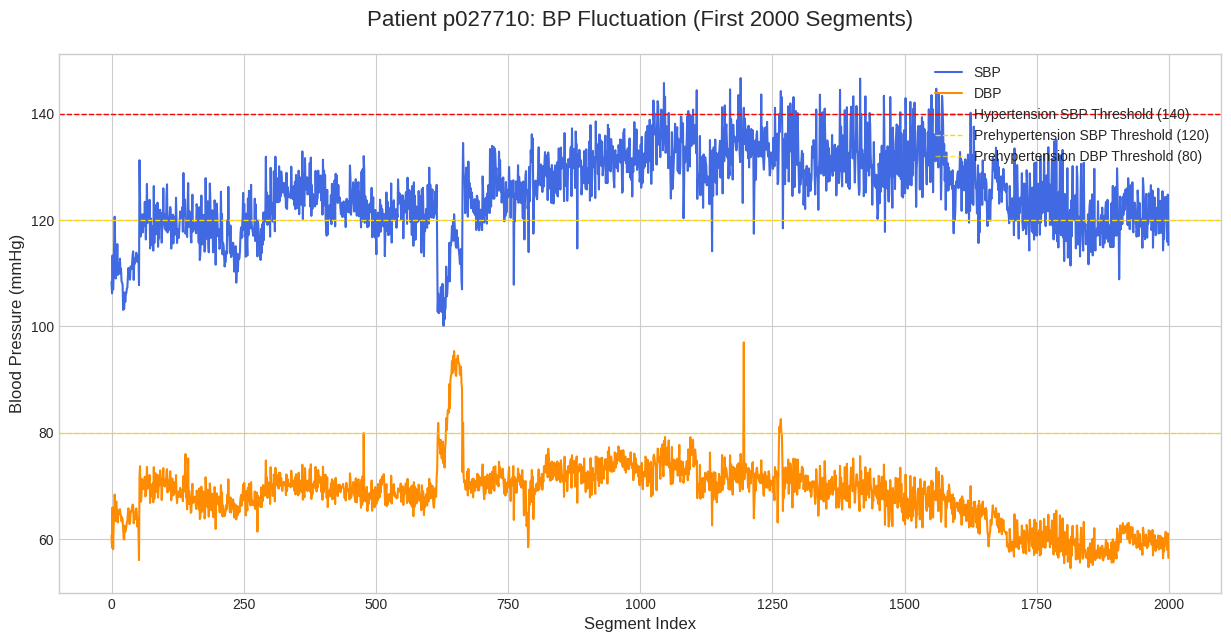

In [7]:
# 그래프 생성
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 7))

# SBP와 DBP 데이터 그리기
ax.plot(df_vis['Segment'], df_vis['SBP'], label='SBP', color='royalblue', linewidth=1.5)
ax.plot(df_vis['Segment'], df_vis['DBP'], label='DBP', color='darkorange', linewidth=1.5)

# 그래프의 가독성을 높이기 위한 추가 요소
ax.axhline(y=140, color='red', linestyle='--', linewidth=1, label='Hypertension SBP Threshold (140)')
ax.axhline(y=120, color='gold', linestyle='--', linewidth=1, label='Prehypertension SBP Threshold (120)')
ax.axhline(y=80, color='gold', linestyle='--', linewidth=1, alpha=0.7, label='Prehypertension DBP Threshold (80)')

# 제목 및 축 레이블 설정
ax.set_title('Patient p027710: BP Fluctuation (First 2000 Segments)', fontsize=16, pad=20)
ax.set_xlabel('Segment Index', fontsize=12)
ax.set_ylabel('Blood Pressure (mmHg)', fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# 그래프 출력
plt.show()

## 5-Fold 교차 검증을 위한 데이터 분할

In [8]:
# 1. 과제에 사용할 데이터 선택 (환자 A)
n_segments_total = 2000
df_model = df.head(n_segments_total).copy()

# 2. 입력 데이터(X) 생성: PPG 신호만으로 3차원 배열 생성
# CNN 입력 형태: (샘플 수, 신호 길이, 채널 수)
# 채널 0: PPG
X_signals = np.stack(df_model['PPG'].values)
X_signals = np.expand_dims(X_signals, axis=-1) # 채널 차원 추가

# 3. 타겟 데이터(y) 생성: SBP와 DBP
y_targets = df_model[['SBP', 'DBP']].values

print("✅ CNN 입력을 위한 데이터 변환이 완료되었습니다.")
print(f"입력 데이터(X)의 형태: {X_signals.shape}")
print(f"타겟 데이터(y)의 형태: {y_targets.shape}")

✅ CNN 입력을 위한 데이터 변환이 완료되었습니다.
입력 데이터(X)의 형태: (2000, 1250, 1)
타겟 데이터(y)의 형태: (2000, 2)


## 모델 정의

In [9]:
# 모델 1: CNN
def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(100, activation='relu'),
        Dropout(0.3),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    return model

In [10]:
# 모델 2: LSTM
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32),
        Dense(50, activation='relu'),
        Dropout(0.3),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    return model

In [11]:
# 모델 3: CNN-LSTM Hybrid
def build_cnn_lstm_model(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        LSTM(32),
        Dense(50, activation='relu'),
        Dropout(0.3),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    return model

In [12]:
# 모델 4: Final Model (Inception-style CNN + Stacked Bi-GRU + Attention)
def build_final_model(input_shape):
    inputs = Input(shape=input_shape)

    # --- 1. Inception-style Block for Multi-scale Feature Extraction ---
    # Branch 1: Small kernel
    tower_1 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(inputs)
    tower_1 = BatchNormalization()(tower_1)

    # Branch 2: Medium kernel
    tower_2 = Conv1D(filters=32, kernel_size=7, padding='same', activation='relu')(inputs)
    tower_2 = BatchNormalization()(tower_2)

    # Branch 3: Large kernel
    tower_3 = Conv1D(filters=32, kernel_size=11, padding='same', activation='relu')(inputs)
    tower_3 = BatchNormalization()(tower_3)

    # Concatenate branches
    x = Concatenate(axis=-1)([tower_1, tower_2, tower_3])
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.2)(x)

    # --- 2. Stacked Bi-directional GRU ---
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    gru_output = Bidirectional(GRU(64, return_sequences=True))(x)

    # --- 3. Attention & Pooling ---
    attention_output = Attention()([gru_output, gru_output])
    pooled_output = GlobalAveragePooling1D()(attention_output)

    # --- 4. Dense layers ---
    x = Dense(128, activation='relu')(pooled_output)
    x = Dropout(0.3)(x)
    outputs = Dense(2)(x)

    # --- 5. Model Compilation ---
    # 학습률을 조정한 Adam 옵티마이저 사용
    optimizer = Adam(learning_rate=0.0005)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])
    return model

## 손실 시각화 함수 정의

In [13]:
def plot_average_loss(histories, model_name):
    """
    교차 검증 결과로 얻은 history 리스트를 받아,
    평균 훈련/검증 손실과 표준편차를 시각화하는 함수.
    """
    # 모든 폴드의 'loss'와 'val_loss'를 리스트에 저장
    train_losses = [h.history['loss'] for h in histories]
    val_losses = [h.history['val_loss'] for h in histories]

    # EarlyStopping으로 인해 epoch 수가 다를 수 있으므로, 가장 짧은 epoch 길이에 맞춰 자름
    min_epochs = min(len(loss) for loss in train_losses)
    train_losses_truncated = [loss[:min_epochs] for loss in train_losses]
    val_losses_truncated = [loss[:min_epochs] for loss in val_losses]

    # NumPy 배열로 변환
    train_losses_np = np.array(train_losses_truncated)
    val_losses_np = np.array(val_losses_truncated)

    # epoch별 평균 및 표준편차 계산
    avg_train_loss = np.mean(train_losses_np, axis=0)
    std_train_loss = np.std(train_losses_np, axis=0)
    avg_val_loss = np.mean(val_losses_np, axis=0)
    std_val_loss = np.std(val_losses_np, axis=0)

    epochs = range(1, min_epochs + 1)

    # 시각화
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))

    # 평균 훈련 손실 (실선) 및 표준편차 (음영)
    plt.plot(epochs, avg_train_loss, 'b-', label='Average Train Loss')
    plt.fill_between(epochs, avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, color='blue', alpha=0.2)

    # 평균 검증 손실 (실선) 및 표준편차 (음영)
    plt.plot(epochs, avg_val_loss, 'r-', label='Average Validation Loss')
    plt.fill_between(epochs, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, color='red', alpha=0.2)

    plt.title(f'{model_name} - Average Training & Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss (MAE)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
def plot_final_training_loss(history, model_name):
    """
    단일 학습 결과(history)를 받아 훈련 손실을 시각화하는 함수.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))

    plt.plot(history.history['loss'], 'b-', label='Training Loss')

    plt.title(f'{model_name} - Final Training Loss on Patient A', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss (MAE)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

## 모델 1 - CNN 모델 학습/평가

In [15]:
# 교차 검증 설정
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# CNN 모델 성능 저장 리스트
cnn_mae_sbp_scores = []
cnn_mae_dbp_scores = []
cnn_rmse_scores = []
cnn_histories = []

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [16]:
# CNN 교차 검증 루프
print("\n--- 🚀 CNN 모델 5-Fold 교차 검증 시작 ---")
for fold, (train_index, test_index) in enumerate(kf.split(X_signals, y_targets)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")
    X_train, X_test = X_signals[train_index], X_signals[test_index]
    y_train, y_test = y_targets[train_index], y_targets[test_index]
    input_shape = (X_train.shape[1], X_train.shape[2])

    model = build_cnn_model(input_shape)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    cnn_histories.append(history)

    y_pred = model.predict(X_test, verbose=0)
    mae_sbp = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
    mae_dbp = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    cnn_mae_sbp_scores.append(mae_sbp)
    cnn_mae_dbp_scores.append(mae_dbp)
    cnn_rmse_scores.append(rmse)
    print(f"MAE_SBP: {mae_sbp:.4f}, MAE_DBP: {mae_dbp:.4f}, RMSE: {rmse:.4f}")


--- 🚀 CNN 모델 5-Fold 교차 검증 시작 ---

--- Fold 1/5 ---
MAE_SBP: 8.4401, MAE_DBP: 5.7950, RMSE: 9.1233

--- Fold 2/5 ---
MAE_SBP: 7.8084, MAE_DBP: 4.5458, RMSE: 7.9010

--- Fold 3/5 ---
MAE_SBP: 8.1099, MAE_DBP: 5.1964, RMSE: 8.6017

--- Fold 4/5 ---
MAE_SBP: 7.9239, MAE_DBP: 5.2140, RMSE: 8.2373

--- Fold 5/5 ---
MAE_SBP: 9.1388, MAE_DBP: 5.9987, RMSE: 9.4991


In [17]:
# CNN 최종 성능 요약
print("\n--- 📊 CNN 모델 최종 성능 ---")
print(f"평균 MAE (SBP): {np.mean(cnn_mae_sbp_scores):.4f} (±{np.std(cnn_mae_sbp_scores):.4f})")
print(f"평균 MAE (DBP): {np.mean(cnn_mae_dbp_scores):.4f} (±{np.std(cnn_mae_dbp_scores):.4f})")
print(f"평균 RMSE: {np.mean(cnn_rmse_scores):.4f} (±{np.std(cnn_rmse_scores):.4f})")


--- 📊 CNN 모델 최종 성능 ---
평균 MAE (SBP): 8.2842 (±0.4777)
평균 MAE (DBP): 5.3500 (±0.5114)
평균 RMSE: 8.6725 (±0.5790)


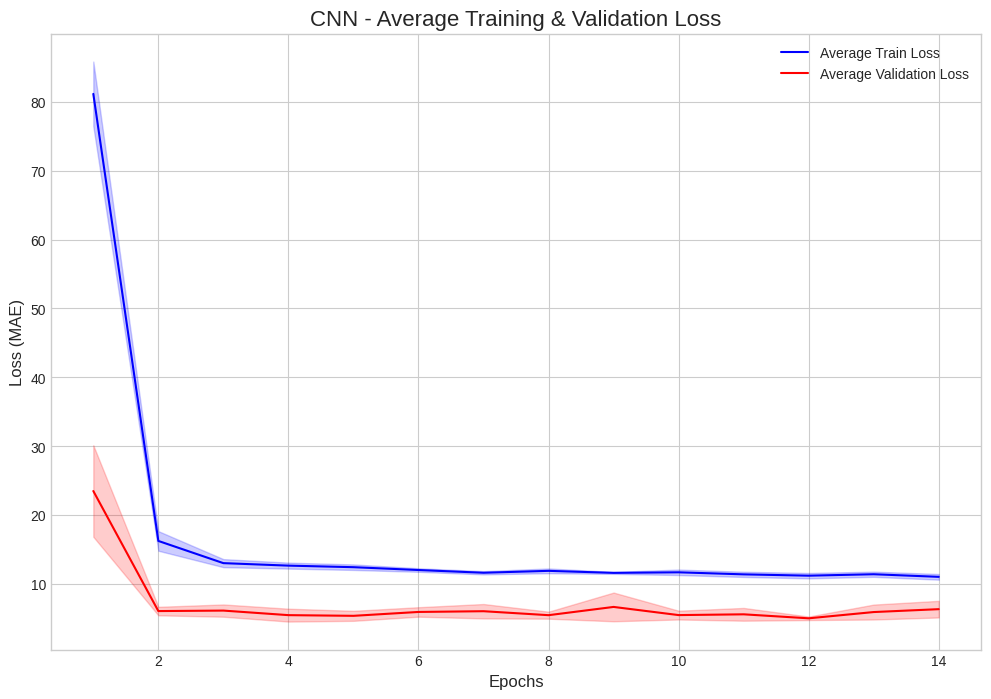

In [18]:
plot_average_loss(cnn_histories, 'CNN')

## 모델 2 - LSTM 모델 학습/평가

In [19]:
# LSTM 모델 성능 저장 리스트
lstm_mae_sbp_scores = []
lstm_mae_dbp_scores = []
lstm_rmse_scores = []
lstm_histories = []

In [20]:
# LSTM 교차 검증 루프
print("\n--- 🚀 LSTM 모델 5-Fold 교차 검증 시작 ---")
for fold, (train_index, test_index) in enumerate(kf.split(X_signals, y_targets)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")
    X_train, X_test = X_signals[train_index], X_signals[test_index]
    y_train, y_test = y_targets[train_index], y_targets[test_index]
    input_shape = (X_train.shape[1], X_train.shape[2])

    model = build_lstm_model(input_shape)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    lstm_histories.append(history)

    y_pred = model.predict(X_test, verbose=0)
    mae_sbp = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
    mae_dbp = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    lstm_mae_sbp_scores.append(mae_sbp)
    lstm_mae_dbp_scores.append(mae_dbp)
    lstm_rmse_scores.append(rmse)
    print(f"MAE_SBP: {mae_sbp:.4f}, MAE_DBP: {mae_dbp:.4f}, RMSE: {rmse:.4f}")


--- 🚀 LSTM 모델 5-Fold 교차 검증 시작 ---

--- Fold 1/5 ---
MAE_SBP: 6.7901, MAE_DBP: 4.3592, RMSE: 7.3694

--- Fold 2/5 ---
MAE_SBP: 6.5178, MAE_DBP: 4.3405, RMSE: 6.9430

--- Fold 3/5 ---
MAE_SBP: 6.9785, MAE_DBP: 4.6324, RMSE: 7.3415

--- Fold 4/5 ---
MAE_SBP: 7.3151, MAE_DBP: 4.9279, RMSE: 7.6658

--- Fold 5/5 ---
MAE_SBP: 6.6542, MAE_DBP: 5.0947, RMSE: 7.5452


In [21]:
# LSTM 최종 성능 요약
print("\n--- 📊 LSTM 모델 최종 성능 ---")
print(f"평균 MAE (SBP): {np.mean(lstm_mae_sbp_scores):.4f} (±{np.std(lstm_mae_sbp_scores):.4f})")
print(f"평균 MAE (DBP): {np.mean(lstm_mae_dbp_scores):.4f} (±{np.std(lstm_mae_dbp_scores):.4f})")
print(f"평균 RMSE: {np.mean(lstm_rmse_scores):.4f} (±{np.std(lstm_rmse_scores):.4f})")


--- 📊 LSTM 모델 최종 성능 ---
평균 MAE (SBP): 6.8511 (±0.2775)
평균 MAE (DBP): 4.6709 (±0.3012)
평균 RMSE: 7.3730 (±0.2455)


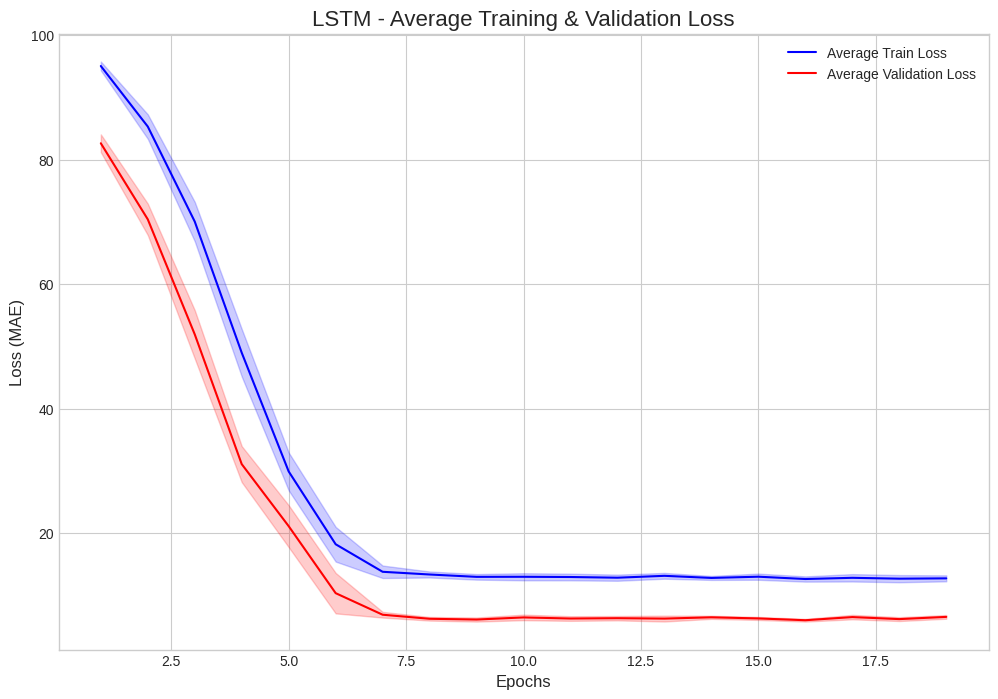

In [22]:
plot_average_loss(lstm_histories, 'LSTM')

## 모델 3 - CNN-LSTM 모델 학습/평가

In [23]:
# CNN-LSTM 모델 성능 저장 리스트
cnn_lstm_mae_sbp_scores = []
cnn_lstm_mae_dbp_scores = []
cnn_lstm_rmse_scores = []
cnn_lstm_histories = []

In [24]:
# CNN-LSTM 교차 검증 루프
print("\n--- 🚀 CNN-LSTM 모델 5-Fold 교차 검증 시작 ---")
for fold, (train_index, test_index) in enumerate(kf.split(X_signals, y_targets)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")
    X_train, X_test = X_signals[train_index], X_signals[test_index]
    y_train, y_test = y_targets[train_index], y_targets[test_index]
    input_shape = (X_train.shape[1], X_train.shape[2])

    model = build_cnn_lstm_model(input_shape)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    cnn_lstm_histories.append(history)

    y_pred = model.predict(X_test, verbose=0)
    mae_sbp = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
    mae_dbp = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    cnn_lstm_mae_sbp_scores.append(mae_sbp)
    cnn_lstm_mae_dbp_scores.append(mae_dbp)
    cnn_lstm_rmse_scores.append(rmse)
    print(f"MAE_SBP: {mae_sbp:.4f}, MAE_DBP: {mae_dbp:.4f}, RMSE: {rmse:.4f}")


--- 🚀 CNN-LSTM 모델 5-Fold 교차 검증 시작 ---

--- Fold 1/5 ---
MAE_SBP: 6.7560, MAE_DBP: 4.5615, RMSE: 7.4009

--- Fold 2/5 ---
MAE_SBP: 6.5129, MAE_DBP: 4.3828, RMSE: 6.9514

--- Fold 3/5 ---
MAE_SBP: 6.9119, MAE_DBP: 5.0899, RMSE: 7.4489

--- Fold 4/5 ---
MAE_SBP: 7.9829, MAE_DBP: 4.7443, RMSE: 8.0699

--- Fold 5/5 ---
MAE_SBP: 6.7018, MAE_DBP: 4.8469, RMSE: 7.4972


In [25]:
# CNN-LSTM 최종 성능 요약
print("\n--- 📊 CNN-LSTM 모델 최종 성능 ---")
print(f"평균 MAE (SBP): {np.mean(cnn_lstm_mae_sbp_scores):.4f} (±{np.std(cnn_lstm_mae_sbp_scores):.4f})")
print(f"평균 MAE (DBP): {np.mean(cnn_lstm_mae_dbp_scores):.4f} (±{np.std(cnn_lstm_mae_dbp_scores):.4f})")
print(f"평균 RMSE: {np.mean(cnn_lstm_rmse_scores):.4f} (±{np.std(cnn_lstm_rmse_scores):.4f})")


--- 📊 CNN-LSTM 모델 최종 성능 ---
평균 MAE (SBP): 6.9731 (±0.5208)
평균 MAE (DBP): 4.7251 (±0.2418)
평균 RMSE: 7.4737 (±0.3563)


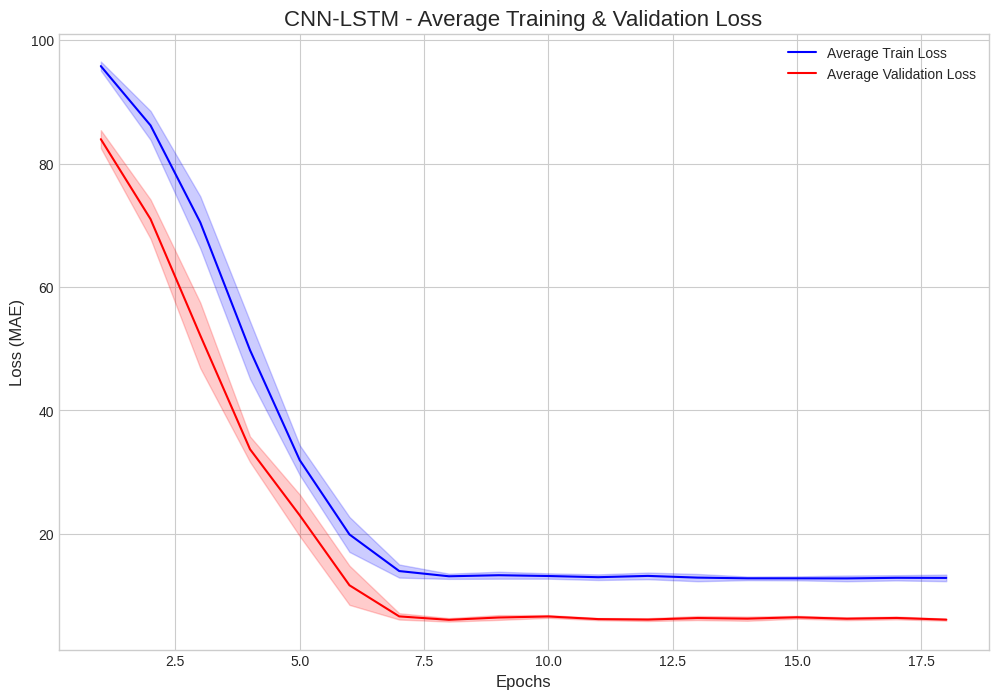

In [26]:
plot_average_loss(cnn_lstm_histories, 'CNN-LSTM')

## 모델 4 - Final 모델 학습/평가

In [27]:
# 모델 성능 저장 리스트
final_mae_sbp_scores = []
final_mae_dbp_scores = []
final_rmse_scores = []
final_histories = []

In [28]:
# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [29]:
# 교차 검증 루프
print("\n--- 🚀 Final Model 5-Fold 교차 검증 시작 ---")
for fold, (train_index, test_index) in enumerate(kf.split(X_signals, y_targets)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")
    X_train, X_test = X_signals[train_index], X_signals[test_index]
    y_train, y_test = y_targets[train_index], y_targets[test_index]
    input_shape = (X_train.shape[1], X_train.shape[2])

    model = build_final_model(input_shape)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    final_histories.append(history)

    y_pred = model.predict(X_test, verbose=0)
    mae_sbp = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
    mae_dbp = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    final_mae_sbp_scores.append(mae_sbp)
    final_mae_dbp_scores.append(mae_dbp)
    final_rmse_scores.append(rmse)
    print(f"MAE_SBP: {mae_sbp:.4f}, MAE_DBP: {mae_dbp:.4f}, RMSE: {rmse:.4f}")


--- 🚀 Final Model 5-Fold 교차 검증 시작 ---

--- Fold 1/5 ---
MAE_SBP: 6.5616, MAE_DBP: 4.2997, RMSE: 7.1685

--- Fold 2/5 ---
MAE_SBP: 6.2079, MAE_DBP: 4.2913, RMSE: 6.7266

--- Fold 3/5 ---
MAE_SBP: 6.4672, MAE_DBP: 4.4638, RMSE: 6.9552

--- Fold 4/5 ---
MAE_SBP: 6.7531, MAE_DBP: 4.4840, RMSE: 7.1296

--- Fold 5/5 ---
MAE_SBP: 6.0646, MAE_DBP: 4.6749, RMSE: 7.0472


In [30]:
# 최종 성능 요약
print("\n--- 📊 Final Model 최종 성능 ---")
print(f"평균 MAE (SBP): {np.mean(final_mae_sbp_scores):.4f} (±{np.std(final_mae_sbp_scores):.4f})")
print(f"평균 MAE (DBP): {np.mean(final_mae_dbp_scores):.4f} (±{np.std(final_mae_dbp_scores):.4f})")
print(f"평균 RMSE: {np.mean(final_rmse_scores):.4f} (±{np.std(final_rmse_scores):.4f})")


--- 📊 Final Model 최종 성능 ---
평균 MAE (SBP): 6.4109 (±0.2466)
평균 MAE (DBP): 4.4427 (±0.1410)
평균 RMSE: 7.0054 (±0.1575)


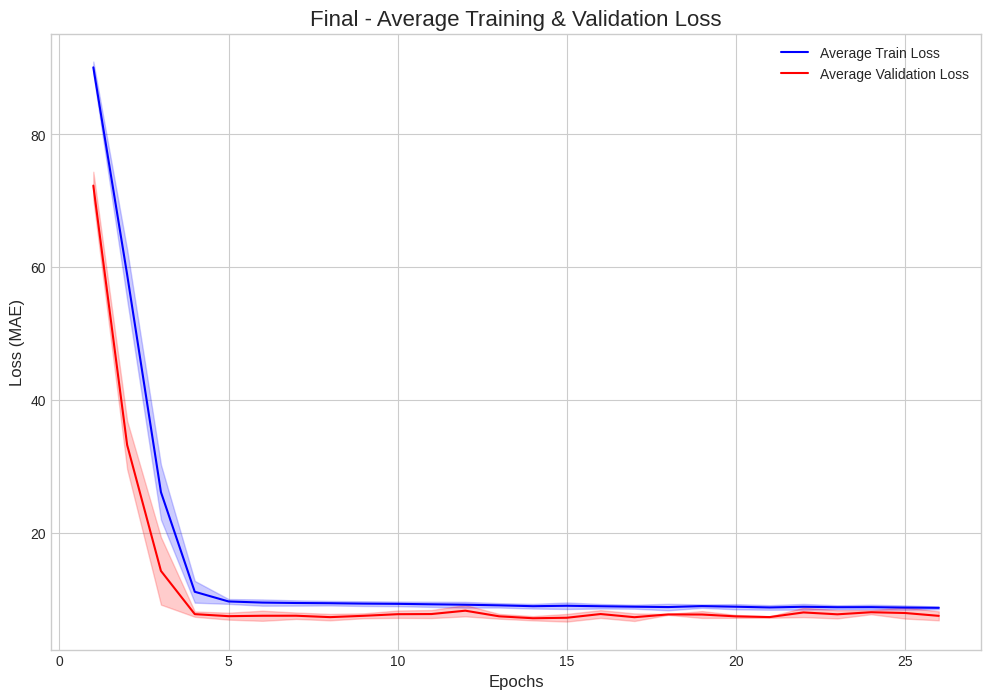

In [31]:
plot_average_loss(final_histories, 'Final')

## 환자 B 데이터 로드 및 가장 우수한 모델로 최종 테스트

In [32]:
file_path_b = '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/week05 (MATLAB dataset)/p044036.mat'
with h5py.File(file_path_b, 'r') as mat_file:
    subj_wins_group = mat_file['Subj_Wins']
    ppg_refs_b = subj_wins_group['PPG_F'][()]
    sbp_refs_b = subj_wins_group['SegSBP'][()]
    dbp_refs_b = subj_wins_group['SegDBP'][()]
    ppg_signals_b = [mat_file[ref][()].flatten() for ref in ppg_refs_b.flatten()]
    sbp_b = np.array([mat_file[ref][()].flatten()[0] for ref in sbp_refs_b.flatten()])
    dbp_b = np.array([mat_file[ref][()].flatten()[0] for ref in dbp_refs_b.flatten()])
    df_b = pd.DataFrame({'PPG': ppg_signals_b, 'SBP': sbp_b, 'DBP': dbp_b})

In [33]:
print(f"✅ 환자 B({file_path_b}) 데이터 로드 완료. 총 {len(df_b)}개 세그먼트.")

✅ 환자 B(/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/week05 (MATLAB dataset)/p044036.mat) 데이터 로드 완료. 총 1696개 세그먼트.


In [34]:
# 2. 환자 B 테스트 데이터 준비 (환자 A와 동일한 범위)
df_test_b = df_b.head(n_segments_total).copy()
X_test_b = np.stack(df_test_b['PPG'].values)
X_test_b = np.expand_dims(X_test_b, axis=-1)
y_test_b = df_test_b[['SBP', 'DBP']].values

print(f"환자 B 테스트 데이터(X) 형태: {X_test_b.shape}")
print(f"환자 B 테스트 타겟(y) 형태: {y_test_b.shape}")

환자 B 테스트 데이터(X) 형태: (1696, 1250, 1)
환자 B 테스트 타겟(y) 형태: (1696, 2)


In [35]:
# 3. 환자 A 전체 데이터로 최종 모델(Final Model) 재학습
print("\n--- 🚀 환자 A 전체 데이터로 최종 Final Model 학습 ---")
input_shape = (X_signals.shape[1], X_signals.shape[2])
final_model = build_final_model(input_shape)

# .fit()의 결과를 history 변수에 저장
final_history = final_model.fit(X_signals, y_targets, epochs=100, batch_size=32, verbose=1)


--- 🚀 환자 A 전체 데이터로 최종 Final Model 학습 ---
Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 91.0634 - mae: 91.0634
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 45.8266 - mae: 45.8266
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 14.3481 - mae: 14.3481
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 9.6287 - mae: 9.6287
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 9.7779 - mae: 9.7779
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 9.6344 - mae: 9.6344
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 9.0960 - mae: 9.0960
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 9.2442 - mae: 9.2442
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 9.0377 - mae: 9.0377
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 9.1679 - mae: 9.1679
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 9.1512 - mae: 9.1512
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss

In [36]:
# 4. 환자 B 데이터로 최종 평가
print("\n--- 📊 환자 B 데이터에 대한 최종 성능 평가 ---")
y_pred_final = final_model.predict(X_test_b)

# SBP, DBP MAE 개별 계산
final_mae_sbp = mean_absolute_error(y_test_b[:, 0], y_pred_final[:, 0])
final_mae_dbp = mean_absolute_error(y_test_b[:, 1], y_pred_final[:, 1])
final_rmse = np.sqrt(mean_squared_error(y_test_b, y_pred_final))

print(f"환자 B 최종 테스트 MAE (SBP): {final_mae_sbp:.4f}")
print(f"환자 B 최종 테스트 MAE (DBP): {final_mae_dbp:.4f}")
print(f"환자 B 최종 테스트 RMSE: {final_rmse:.4f}")


--- 📊 환자 B 데이터에 대한 최종 성능 평가 ---
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
환자 B 최종 테스트 MAE (SBP): 6.1489
환자 B 최종 테스트 MAE (DBP): 2.7871
환자 B 최종 테스트 RMSE: 5.9986


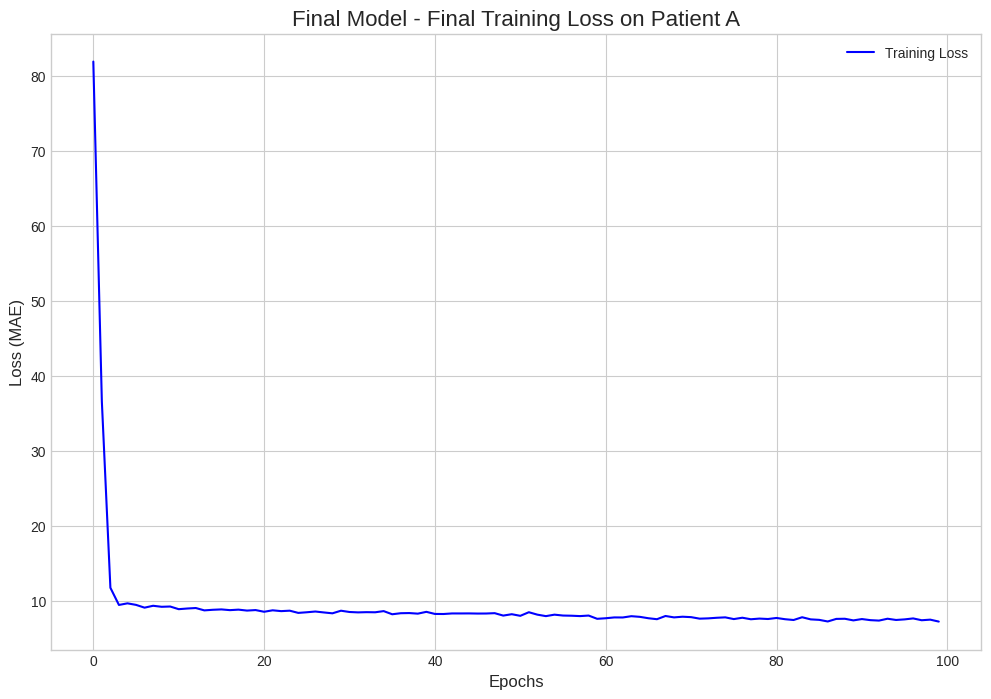

In [38]:
plot_final_training_loss(final_history, 'Final Model')